# 0. Imports

In [ ]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import random, randint
from queue import PriorityQueue
from copy import deepcopy
from time import time
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 0.1 Accessibility

In [ ]:
colorVisionDeficiencyMode = False

# 1. Helper Classes

## 1.1 Perlin Noise

In [ ]:
# Perline noise code courtesy of tgroid on SO
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u)
    return lerp(x1,x2,v)

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

if __name__ == 'main':
    lin = np.linspace(0,5,100,endpoint=False)
    x,y = np.meshgrid(lin,lin)

    plt.imshow(perlin(x,y,seed=5),origin='upper')
    plt.show()

## 1.2 Point

In [ ]:
class Point():

	def __init__(self, posx, posy):
		self.x = posx
		self.y = posy
		self.comparator = math.inf

	def __lt__(self, other):
		return self.comparator < other.comparator

	def __gt__(self, other):
		return self.comparator > other.comparator

	def __eq__(self, other):
		return self.x == other.x and self.y == other.y

## 1.3 Map

In [ ]:
def scale(X):
	X = ((X+1)/2 * 255).astype(int)
	return X

class Map():

	def __init__(self, length, width, cost_function='exp',seed=None,
	             filename=None, start=None, goal=None):

		self.seed = seed
		if self.seed == None:
			# Randomly assign seed from 0 to 10k if not provided
			self.seed = randint(0,10000)
		self.length = length
		self.width = width
		self.generateTerrain(filename)
		self.explored = []
		self.explored_lookup = {}
		for i in range(self.width):
			for j in range(self.length):
				self.explored_lookup[str(i)+','+str(j)] = False
		if start == None:
			self.start = Point(int(self.width*0.5),int(self.length*0.5))
		else:
			self.start = Point(start[0], start[1])
		if goal == None:
			self.goal = Point(int((self.width-1)*0.9),int((self.length-1)*0.9))
		else:
			self.goal = Point(goal[0], goal[1])
		if cost_function == 'exp':
			self.cost_function = lambda h0, h1: math.pow(math.e,h1-h0)
		elif cost_function == 'div':
			self.cost_function = lambda h0, h1: h0/(h1+1)
		self.cmap = mpl.colors.ListedColormap(['white', 'red'])
		if colorVisionDeficiencyMode:
			self.cmap = mpl.colors.ListedColormap(['white', 'magenta'])

	'''generateTerrain: modifes self.map to either be the specified file, or
	randomly generated from perlin noise.
	input:
	filename - str, string of the npy file to generate the map
	seed - int, integer for reproducibility of a particular map
	octaves - int parameter for perlin noise
	output:
	None, self.map modified'''
	def generateTerrain(self, filename=None):
		if filename is None:
			linx = np.linspace(0,5,self.width,endpoint=False)
			liny = np.linspace(0,5,self.length,endpoint=False)
			x,y = np.meshgrid(linx,liny)
			self.map = scale(perlin(x, y, seed=self.seed))

		else:
			self.map = np.load(filename)
			self.width = self.map.shape[0]
			self.length = self.map.shape[1]

	def interpolate(self, a0, a1, w):
		if (0.0 > w):
			return a0
		if (1.0 < w):
			return a1
		return (a1 - a0) * ((w * (w * 6.0 - 15.0) + 10.0) * w ** 3) + a0

	def calculatePathCost(self, path):
		prev = path[0]
		if self.start != prev:
			print('Path does not start at start. Path starts at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		cost = 0
		for item in path[1:]:
			if self.isAdjacent(prev, item):
				cost += self.getCost(prev, item)
				prev = item
			else:
				print('Path does not connect at points: ', str(prev.x), ',', str(prev.y),
					' and ', str(item.x), ',', str(item.y))
				return math.inf
		if prev != self.goal:
			print('Path does not end at goal. Path ends at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		return cost

	def validTile(self, x, y):
		return x >= 0 and y >= 0 and x < self.width and y < self.length

	'''def validTile(self, p1):
		return self.validTile(p1.x, p1.y)'''

	def getTile(self, x, y):
		return self.map[x][y]

	'''def getTile(self, p1):
		return self.getTile(p1.x, p1.y)'''

	def getCost(self, p1, p2):
		h0 = self.getTile(p1.x, p1.y)
		h1 = self.getTile(p2.x, p2.y)
		return self.cost_function(h0, h1)

	def isAdjacent(self, p1, p2):
		return (abs(p1.x - p2.x) == 1 or abs(p1.y - p2.y)) == 1 and (abs(p1.x - p2.x) < 2 and abs(p1.y - p2.y) < 2)

	def getNeighbors(self, p1):
		neighbors = []
		for i in [-1, 0, 1]:
			for j in [-1, 0, 1]:
				if i == 0 and j == 0:
					continue
				possible_point = Point(p1.x + i, p1.y + j)
				if self.validTile(possible_point.x, possible_point.y):
					neighbors.append(possible_point)
					if not self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)]:
						self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)] = True
						self.explored.append(possible_point)
		return neighbors

	def getStartPoint(self):
		return self.start

	def getEndPoint(self):
		return self.goal

	def getHeight(self):
		return np.amax(self.map)

	'''Creates a 2D image of the path taken and nodes explroed, prints
	pathcost and number of nodes explored'''
	def createImage(self, path):
		img = self.map
		path_img = np.zeros_like(self.map)
		explored_img = np.zeros_like(self.map)
		for item in self.explored:
			explored_img[item.x, item.y] = 1
		path_img_x = [item.x for item in path]
		path_img_y = [item.y for item in path]
		print('Path cost:', self.calculatePathCost(path))
		print('Nodes explored: ', len(self.explored) + len(path))
		plt.imshow(img, cmap='gray')
		plt.imshow(explored_img, cmap=self.cmap, alpha=0.3)
		plt.plot(path_img_y, path_img_x, color='blue', linewidth=1)
		plt.show()

	'''Set the start and goal point on the 2D map, each point is a pair of integers'''
	def setStartGoal(self, start, goal):
		self.start = Point(np.clip(start[0], 0, self.length-1), np.clip(start[1], 0, self.width-1))
		self.goal = Point(np.clip(goal[0], 0, self.length-1), np.clip(goal[1], 0, self.width-1))

# 2. AI Modules

You'll write your code here!

## 2.1 AI Module & Dijkstras

In [ ]:
'''AIModule Interface
createPath(map map_) -> list<points>: Adds points to a path'''
class AIModule:

	def createPath(self, map_):
		pass

'''
A sample AI that takes a very suboptimal path.
This is a sample AI that moves as far horizontally as necessary to reach
the target, then as far vertically as necessary to reach the target.
It is intended primarily as a demonstration of the various pieces of the
program.
'''
class StupidAI(AIModule):

	def createPath(self, map_):
		path = []
		explored = []
		# Get starting point
		path.append(map_.start)
		current_point = deepcopy(map_.start)

		# Keep moving horizontally until we match the target
		while(current_point.x != map_.goal.x):
			# If we are left of goal, move right
			if current_point.x < map_.goal.x:
				current_point.x += 1
			# If we are right of goal, move left
			else:
				current_point.x -= 1
			path.append(deepcopy(current_point))

		# Keep moving vertically until we match the target
		while(current_point.y != map_.goal.y):
			# If we are left of goal, move right
			if current_point.y < map_.goal.y:
				current_point.y += 1
			# If we are right of goal, move left
			else:
				current_point.y -= 1
			path.append(deepcopy(current_point))

		# We're done!
		return path

class Dijkstras(AIModule):

	def createPath(self, map_):
		q = PriorityQueue()
		''' Maintain three dictionaries to keep track of cost ("x,y" -> cost per
		node), previous (node -> parent). This keeps track of paths, and explored
		which helps us run faster by ignoring nodes already visited'''
		cost = {}
		prev = {}
		explored = {}
		# Dictionary initialization
		for i in range(map_.width):
			for j in range(map_.length):
				cost[(i,j)] = math.inf
				prev[(i,j)] = None
				explored[(i,j)] = False
		current_point = deepcopy(map_.start)
		current_point.comparator = 0
		cost[(current_point.x, current_point.y)] = 0
		# Add start node to the queue
		q.put(current_point)
		# Search loop
		while q.qsize() > 0:
			# Get new point from PQ
			v = q.get()
			if explored[(v.x,v.y)]:
				continue
			explored[(v.x,v.y)] = True
			# Check if popping off goal
			if v == map_.getEndPoint():
				break
			# Evaluate neighbors
			neighbors = map_.getNeighbors(v)
			for neighbor in neighbors:
				alt = map_.getCost(v, neighbor) + cost[(v.x,v.y)]
				if alt < cost[(neighbor.x,neighbor.y)]:
					cost[(neighbor.x,neighbor.y)] = alt
					neighbor.comparator = alt
					prev[(neighbor.x,neighbor.y)] = v
				q.put(neighbor)
		# Find and return path
		path = []
		while v != map_.getStartPoint():
			path.append(v)
			v = prev[(v.x,v.y)]
		path.append(map_.getStartPoint())
		path.reverse()
		return path

## 2.2 AIExp and AIMSH
Here, specifically

In [ ]:
class AStarExp(AIModule):

    def heuristic_exp(self, current, goal, map_):
        # Chebyshev distance for chessboard motion
        chebyshev_distance = max(abs(goal.x - current.x), abs(goal.y - current.y))

        # Calculate elevation change
        current_elevation = map_.getTile(current.x, current.y)
        goal_elevation = map_.getTile(goal.x, goal.y)

        # Heuristic for upward movement, considering the 'exp' cost function
        elevation_change_heuristic = 0
        if goal_elevation > current_elevation:
            elevation_change_heuristic = (goal_elevation - current_elevation)

        # Combine the Chebyshev distance with the elevation change
        return ((chebyshev_distance + elevation_change_heuristic)*0.5)

    def createPath(self, map_):
        start = map_.getStartPoint()
        goal = map_.getEndPoint()

        start_key = (start.x, start.y)
        goal_key = (goal.x, goal.y)

        open_set = PriorityQueue()
        open_set.put((0, start_key))  # Priority is f_score, starting node is start

        came_from = {}
        g_score = {start_key: 0}  # Starting node has a g_score of 0
        f_score = {start_key: self.heuristic_exp(start, goal, map_)}  # Starting node's f_score is the heuristic

        while not open_set.empty():
            current_key = open_set.get()[1]  # Get the node with the lowest f_score
            current = Point(current_key[0], current_key[1])

            if current_key == goal_key:
                # Reconstruct path
                path = []
                while current_key in came_from:
                    path.append(Point(current_key[0], current_key[1]))
                    current_key = came_from[current_key]
                path.append(start)
                return path[::-1]  # Return reversed path

            for neighbor in map_.getNeighbors(current):
                neighbor_key = (neighbor.x, neighbor.y)
                tentative_g_score = g_score[current_key] + map_.getCost(current, neighbor)
                if tentative_g_score < g_score.get(neighbor_key, float('inf')):  # Default value if neighbor not in g_score
                    # This path to neighbor is better than any previous one. Record it!
                    came_from[neighbor_key] = current_key
                    g_score[neighbor_key] = tentative_g_score
                    f_score[neighbor_key] = tentative_g_score + self.heuristic_exp(neighbor, goal, map_)
                    if neighbor_key not in [i[1] for i in open_set.queue]:
                        open_set.put((f_score[neighbor_key], neighbor_key))

        return []  # Return an empty path if no path is found

class AStarDiv(AIModule):

    def heuristic_div(self, current, goal, map_):
      # Chebyshev distance for chessboard motion
      chebyshev_distance = max(abs(goal.x - current.x), abs(goal.y - current.y))

      # Calculate elevation change
      current_elevation = map_.getTile(current.x, current.y)
      goal_elevation = map_.getTile(goal.x, goal.y)

      # Heuristic for division cost function
      elevation_change_heuristic = 0
      if goal_elevation > current_elevation:
          elevation_change_heuristic = goal_elevation - current_elevation

      # The heuristic will be the Chebyshev distance reduced by the elevation change heuristic,
      # but not less than zero, to ensure admissibility.
      return max(chebyshev_distance, 0)

    def createPath(self, map_):
        start = map_.getStartPoint()
        goal = map_.getEndPoint()

        open_set = PriorityQueue()
        open_set.put((0, (start.x, start.y)))

        came_from = {}
        g_score = {(x, y): float('inf') for x in range(map_.width) for y in range(map_.length)}
        g_score[(start.x, start.y)] = 0

        f_score = {(x, y): float('inf') for x in range(map_.width) for y in range(map_.length)}
        f_score[(start.x, start.y)] = self.heuristic_div(start, goal, map_)

        while not open_set.empty():
            current = open_set.get()[1]
            current_point = Point(current[0], current[1])

            if current_point == goal:
                path = []
                while current in came_from:
                    path.append(Point(current[0], current[1]))
                    current = came_from[current]
                path.append(start)
                return path[::-1]  # Reversed path

            for neighbor in map_.getNeighbors(current_point):
                neighbor_key = (neighbor.x, neighbor.y)
                tentative_g_score = g_score[current] + map_.getCost(current_point, neighbor)

                if tentative_g_score < g_score[neighbor_key]:
                    came_from[neighbor_key] = current
                    g_score[neighbor_key] = tentative_g_score
                    f_score[neighbor_key] = self.heuristic_div(neighbor, goal, map_)
                    if neighbor_key not in [i[1] for i in open_set.queue]:
                        open_set.put((f_score[neighbor_key], neighbor_key))

        return []  # Return an empty path if no path is found



class AStarMSH(AIModule):

    def heuristic_MSH(self, current, goal, map_):
        # Chebyshev distance for chessboard motion
        chebyshev_distance = max(abs(goal.x - current.x), abs(goal.y - current.y))

        # Calculate elevation change
        current_elevation = map_.getTile(current.x, current.y)
        goal_elevation = map_.getTile(goal.x, goal.y)

        # Heuristic for upward movement, considering the 'exp' cost function
        elevation_change_heuristic = 0
        if goal_elevation > current_elevation:
            elevation_change_heuristic = (goal_elevation - current_elevation)

        # Combine the Chebyshev distance with the elevation change
        # This is a simple heuristic that should be admissible if the actual cost is 'e' to the power of elevation change
        return ((chebyshev_distance + elevation_change_heuristic)*0.5)

    def createPath(self, map_):
        start = map_.getStartPoint()
        goal = map_.getEndPoint()

        start_key = (start.x, start.y)
        goal_key = (goal.x, goal.y)

        open_set = PriorityQueue()
        open_set.put((0, start_key))  # Priority is f_score, starting node is start

        came_from = {}
        g_score = {start_key: 0}  # Starting node has a g_score of 0
        f_score = {start_key: self.heuristic_MSH(start, goal, map_)}  # Starting node's f_score is the heuristic

        while not open_set.empty():
            current_key = open_set.get()[1]  # Get the node with the lowest f_score
            current = Point(current_key[0], current_key[1])

            if current_key == goal_key:
                # Reconstruct path
                path = []
                while current_key in came_from:
                    path.append(Point(current_key[0], current_key[1]))
                    current_key = came_from[current_key]
                path.append(start)
                return path[::-1]  # Return reversed path

            for neighbor in map_.getNeighbors(current):
                neighbor_key = (neighbor.x, neighbor.y)
                tentative_g_score = g_score[current_key] + map_.getCost(current, neighbor)
                if tentative_g_score < g_score.get(neighbor_key, float('inf')):  # Default value if neighbor not in g_score
                    # This path to neighbor is better than any previous one. Record it!
                    came_from[neighbor_key] = current_key
                    g_score[neighbor_key] = tentative_g_score
                    f_score[neighbor_key] = tentative_g_score + self.heuristic_MSH(neighbor, goal, map_)
                    if neighbor_key not in [i[1] for i in open_set.queue]:
                        open_set.put((f_score[neighbor_key], neighbor_key))

        return []  # Return an empty path if no path is found


# 3. Run

## 3.1 Setup

w(int): Width of map

l(int): Length of map

start(array-like<int>): Start position

goal(array-like<int>): Goal position

seed(int): Seed for random generation

AI(AIModule): AI agent to use. Use any of the following: AStarExp, AStarDiv, AStarMSH, Djikstras

filename(string): Filepath for .npy file to be used for map

In [ ]:
w = 500
l = 500
start = None
goal = None
seed = 0
#cost_function = 'exp'
cost_function = 'div'
AI = Dijkstras()
filename = None

NameError: name 'Dijkstras' is not defined

## 3.2 Run

Time (s):  16.398396015167236
Path cost: 241.55253710831192
Nodes explored:  158676


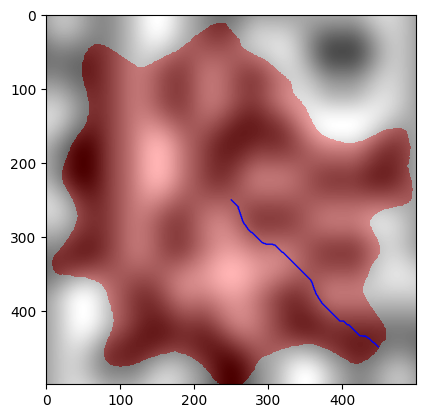

In [ ]:
m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

# 4. Tests

## 4.1 AStarExp

In [ ]:
cost_function = 'exp'

Time (s):  9.817962646484375
Path cost: 241.55253710831192
Nodes explored:  49140


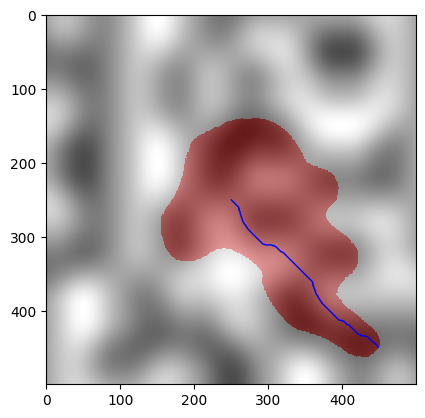

In [ ]:
w = 500
l = 500
start = None
goal = None
seed = 0
# Change to AStarExp() after implemented
AI = AStarExp()
filename = None

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  6.980892658233643
Path cost: 238.5060683830129
Nodes explored:  34661


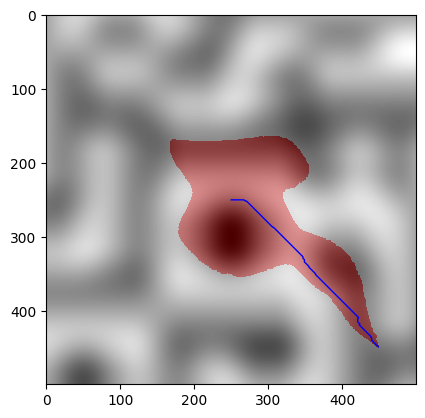

In [ ]:
seed = 1

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  8.97791838645935
Path cost: 236.667690049357
Nodes explored:  41060


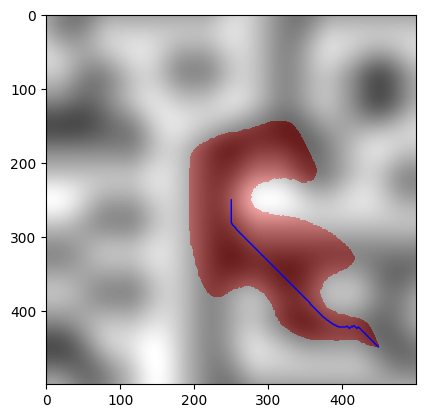

In [ ]:
seed = 2

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  23.08242678642273
Path cost: 422.01798243905006
Nodes explored:  83435


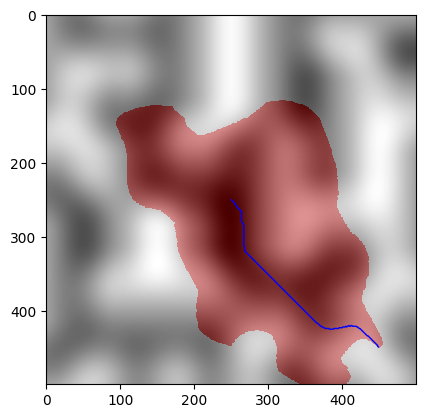

In [ ]:
seed = 3

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  7.930906772613525
Path cost: 254.34464507852198
Nodes explored:  36413


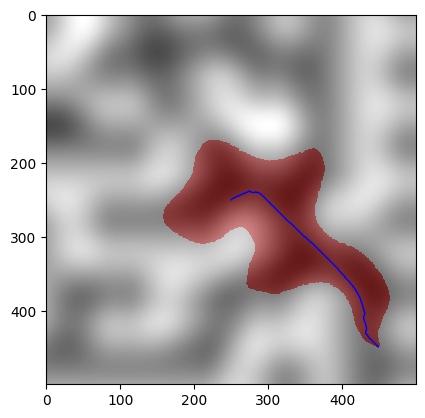

In [ ]:
seed = 4

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

## 4.1 AStarDiv

In [ ]:
cost_function = 'div'

Time (s):  0.30252575874328613
Path cost: 197.67690128917357
Nodes explored:  1199


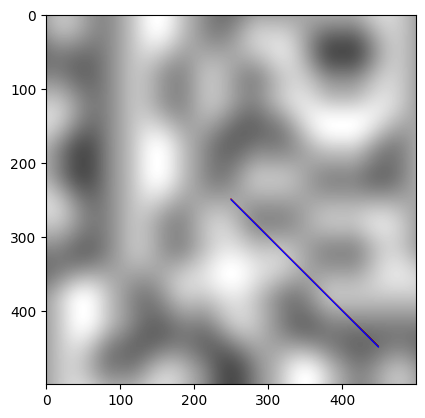

In [ ]:
w = 500
l = 500
start = None
goal = None
seed = 0
# Change to AStarDiv() after implemented
AI = AStarDiv()
filename = None

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.3116021156311035
Path cost: 197.71721595331226
Nodes explored:  1199


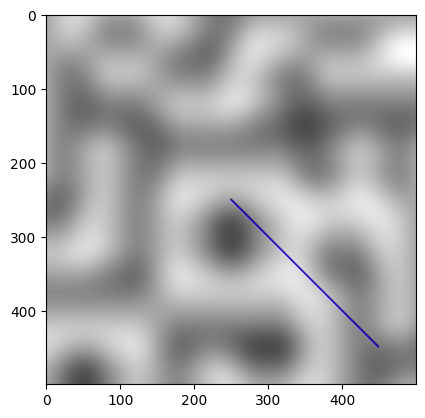

In [ ]:
seed = 1

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.4860265254974365
Path cost: 197.58110211547168
Nodes explored:  1199


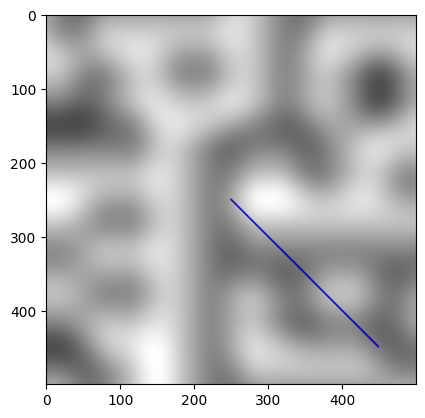

In [ ]:
seed = 2

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.4943256378173828
Path cost: 196.29556836229682
Nodes explored:  1199


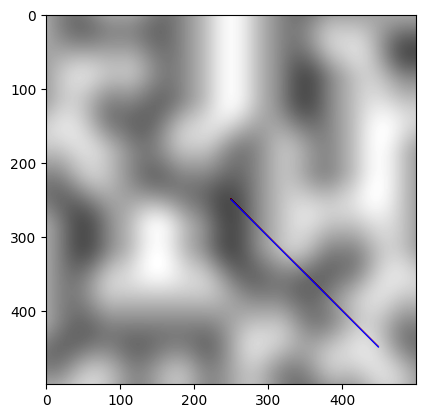

In [ ]:
seed = 3

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.5668108463287354
Path cost: 197.24829713437708
Nodes explored:  1199


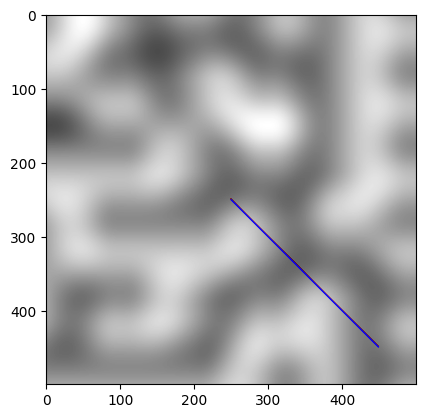

In [ ]:
seed = 4

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

## 4.2 MSH

Time (s):  448.51256680488586
Path cost: 516.0958538621477
Nodes explored:  408682


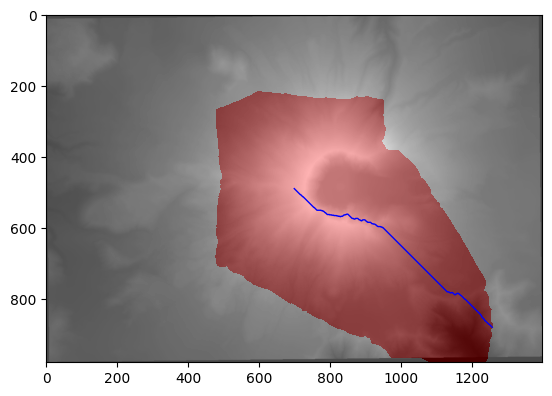

In [ ]:
w = 500
l = 500
start = None
goal = None
seed = 0
# Change to AStarMSH() after implemented
AI = AStarMSH()
# Change to the filepath on your drive
filename = "/content/gdrive/My Drive/ECS170HW1/msh.npy"

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)